In [1]:
import pandas as pd
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Set-up Model Parameters

In [2]:
# load mobility matrix
data = pd.read_csv('../../../Dropbox/Epidemiology/trajectories/nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
# Make up some populations (take as known)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)


[3270. 2404.  550. 2787. 4253. 2758. 1167. 1472. 2702. 1503. 3223.  250.
 1853. 3780. 1544.  757. 1472. 1493.  575. 4430. 2681. 1368. 2261. 1310.
 4058.  524. 3415. 3354.  343. 2590. 3928. 1419. 1156. 2451. 2451.  670.
 1987. 1900. 2136. 2528. 1000.  255. 1794. 3581. 1287. 1642. 2093. 3131.
 3709.  250. 3495. 2737. 1071. 3228.  250. 3114. 1235.  379.  567. 2252.
 1362. 1178.] [ 95912. 118120.  60807.  98624. 111805.  91536.  70968. 115938.  89631.
  87389. 140491. 110761.  59111. 103107. 116178.  95946.  80561. 105742.
  51420. 114463. 147844. 168310. 170693. 155977. 117463.  71088. 120959.
 107308. 125775.  87376. 132091.  67620. 143007.  96250.  78912.  72732.
 125390.  97821. 130489. 114338.  78465.  95010. 104118. 125613.  83909.
 108010.  66998.  94321. 103774.  72888. 121969. 134774. 114010.  98813.
 110971.  96981. 113050.  55713. 128432.  88435. 106596. 130521.]


In [4]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 3)
tmat.add_transition('A', 'I', 3, 3)
tmat.add_transition('I', 'R', 14, 5)
print(tmat.value)
np.sum(tmat.value, axis=1)

[[0.8        0.2        0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


array([1., 1., 1., 1.])

In [5]:
# starting fractions probabilities
start = np.zeros((M,)) - 10 #anywhere
start[0] = 5. # but likely 0

## Make starting joint

In [6]:
param_model = maxentep.MetaParameterJoint(start, R, tmat, name='unbiased')

## Examine some of the statistics

In [7]:
v = param_model.sample(100)

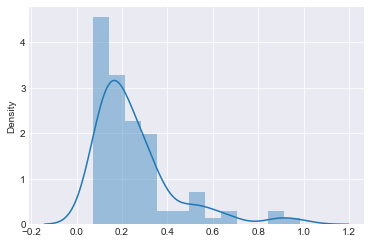

In [8]:
x = v[1][:,compartments.index('E'), compartments.index('A')].numpy()
sns.distplot(x=x)
plt.show()

In [9]:
np.mean(v[1][:, 0, 1]), 1/5

(0.2541625, 0.2)

In [10]:
v[3][4]

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.17412817], dtype=float32)>

In [11]:
# check transition matrix is valud
T = v[1][0].numpy()
print(T)
f = [0.1,0,0,0]
for i in range(1000):
    f = f @ T
    if i % 100 == 0:
        print(f, np.sum(f))

[[0.81501377 0.18498622 0.         0.        ]
 [0.         0.70713836 0.29286164 0.        ]
 [0.         0.         0.8224178  0.1775822 ]
 [0.         0.         0.         1.        ]]
[0.08150138 0.01849862 0.         0.        ] 0.09999999850988389
[1.06575992e-10 1.82757857e-10 9.63371674e-09 9.99999820e-02] 0.0999999919447189
[1.39365035e-19 2.38985062e-19 4.50192106e-17 9.99999919e-02] 0.0999999919447189
[1.82241914e-28 3.12510920e-28 1.63602951e-25 9.99999919e-02] 0.09999999194471887
[2.38310243e-37 4.08657655e-37 5.52261939e-34 9.99999919e-02] 0.09999999194471887
[3.11628487e-46 5.34384779e-46 1.81507951e-42 9.99999919e-02] 0.09999999194471887
[4.07503733e-55 6.98792960e-55 5.90398701e-51 9.99999919e-02] 0.09999999194471887
[5.32875843e-64 9.13782764e-64 1.91251029e-59 9.99999919e-02] 0.09999999194471887
[6.96819786e-73 1.19491607e-72 6.18503172e-68 9.99999919e-02] 0.09999999194471887
[9.11202527e-82 1.56254252e-81 1.99889199e-76 9.99999919e-02] 0.09999999194471887



## Create set of trajectories
The loop is just to batch the trajectories. It is not necessary, just I have my at home GPU which has small RAM.
You could instead just pick `N = 16 * 256` and call once.

In [12]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 256
batches = 4
outs = []
timesteps = 360
infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = MetaModel(infect_fxn, timesteps, populations=population)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.76s/it]

(1024, 360, 62, 5)


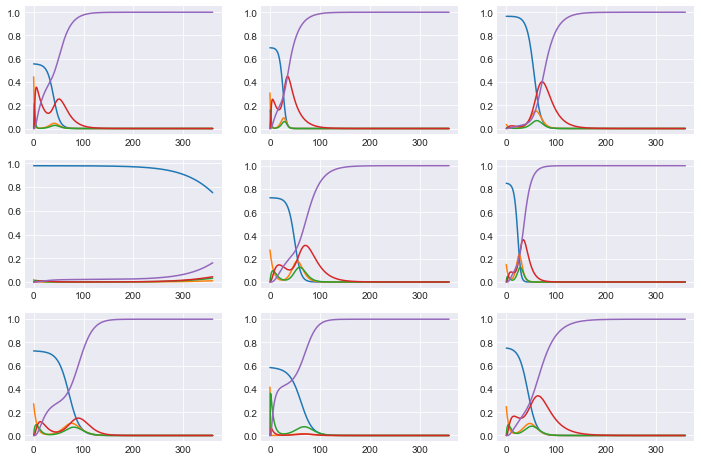

In [13]:
# plot a few trajectories
fig, ax = plt.subplots(3, 3, figsize=(12,8))
for i in range(3):
    for j in range(3):
        ax[i,j].plot(trajs[i * 3 + j,:,0,:])
plt.show()

## Make quantile Plots

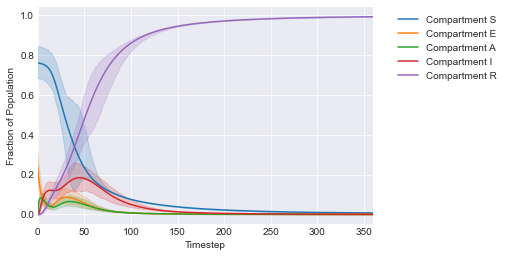

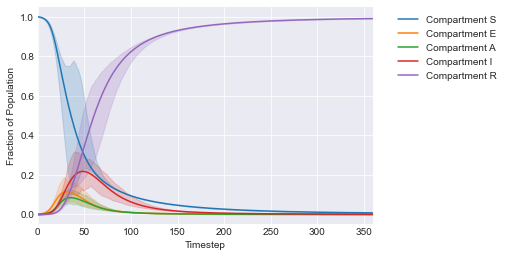

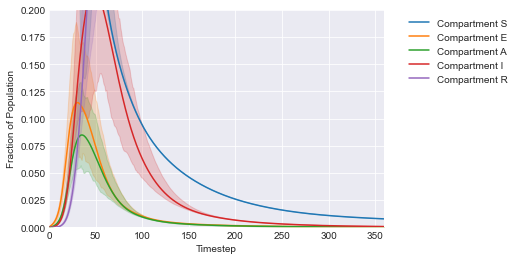

In [14]:
full_compartments = ['S'] + compartments
traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True)
plt.ylim(0,0.2)
plt.show()

## Create arbitrary restraints

In [15]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,300, 1, 4],
    [0.6, 0.1, 250, 34, 4],
    [0.4, 0.1, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxentep.Laplace(uncertainty)
    #p = maxentep.EmptyPrior()
    r = maxentep.Restraint(lambda traj,j=traj_index: traj[j], value, p)
    laplace_restraints.append(r)

## Use maxent model to fit

In [16]:
model = maxentep.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Nadam(learning_rate=1e-2), 'mean_squared_error')

In [17]:
history = model.fit(trajs, batch_size=16, epochs=10, verbose=0)

In [18]:
model.summary()

Model: "maxent-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reweight_layer_laplace (Rewe multiple                  5         
_________________________________________________________________
avg_layer_laplace (AvgLayerL multiple                  5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


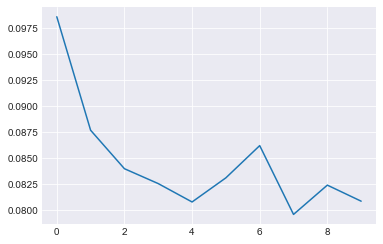

In [19]:
plt.plot(history.history['loss'])

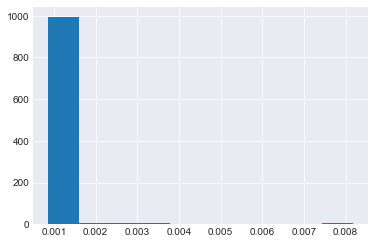

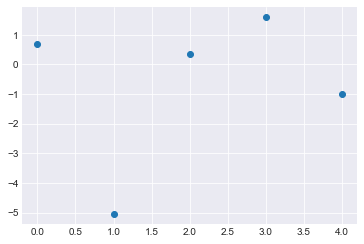

In [20]:
weights = model.traj_weights
plt.hist(weights)
plt.show()
plt.plot(model.lambdas.numpy(), 'o')

## Complete patch plots
disable if you want, they are very slow

In [21]:
#patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
#plt.show()

In [22]:
#patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
#plt.show()

## Final plots showing agreement

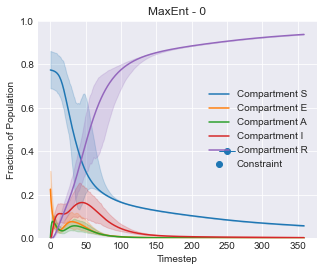

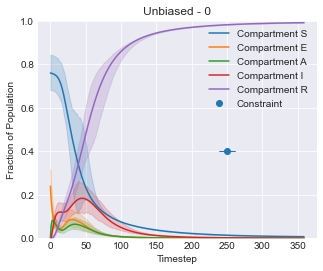

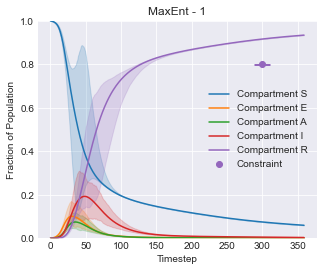

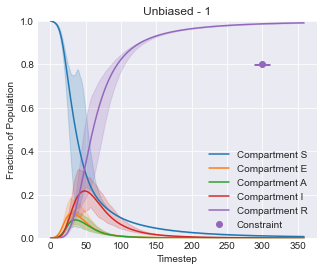

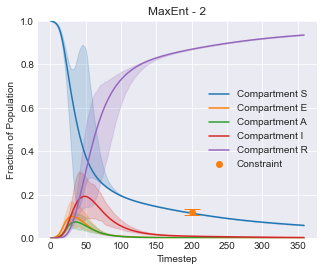

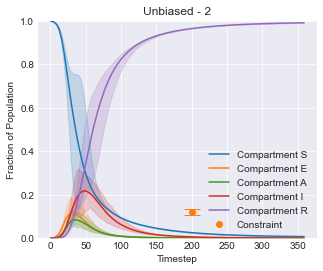

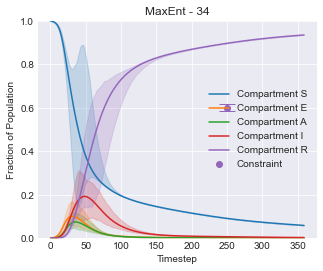

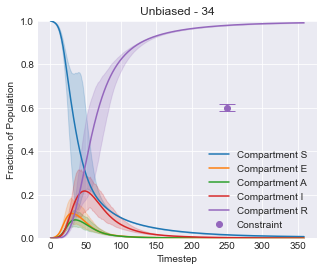

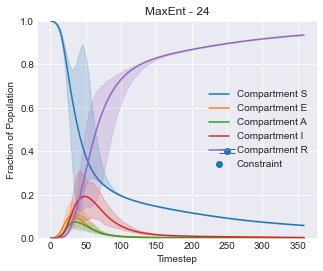

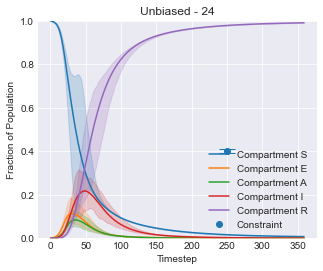

In [23]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()